In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import mlrose_hiive
import matplotlib.pyplot as plt
import time
from random import randint
import random
import numpy as np 
import pandas as pd
from util import *
from functools import partial

In [19]:
import pandas as pd
import numpy as np
import math

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score,roc_auc_score
rand_state = 2022


In [6]:
df_raw = pd.read_csv('data/spaceship-titanic.csv').rename(columns={'Transported':'y'})
df_raw.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,y
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
def preprocess(data_raw, cat_cols = [], num_cols = [], y_col = 'y', drop_cols = []):
    data = data_raw.copy()
    
    for c in cat_cols:
        data.loc[data[c].isnull(),c] = data[c].mode().values[0]
    for c in num_cols:
        data.loc[data[c].isnull(),c] = data[c].median()
    data = pd.get_dummies(data, columns=cat_cols, drop_first = True)
    scaler = MinMaxScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols])
        
    return data.drop(columns=drop_cols)

In [8]:
data = preprocess(df_raw
                  , cat_cols = ['HomePlanet','CryoSleep','VIP','Destination']
                  , num_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
                  , drop_cols = ['PassengerId','Name','Cabin'])
data.head(5)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,y,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,VIP_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,False,1,0,0,0,0,1
1,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,True,0,0,0,0,0,1
2,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,False,1,0,0,1,0,1
3,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,False,1,0,0,0,0,1
4,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,True,0,0,0,0,0,1


In [11]:
split = StratifiedShuffleSplit(n_splits=1 , test_size=0.2, random_state=30)
for train_ind, test_ind in split.split(data, data["y"]):
    trn = data.loc[train_ind]
    test = data.loc[test_ind]

In [13]:
trn_y = trn[['y']]
trn_X = trn.drop(columns=['y'])
test_y = test[['y']]
test_X = test.drop(columns=['y'])

In [33]:
nn = mlrose_hiive.NeuralNetwork(hidden_nodes = [100], activation = 'relu',
                                 algorithm = 'random_hill_climb', 
                                 max_iters = 10000,
                                 learning_rate = 0.1,
                                 early_stopping = True,
                                 max_attempts = 100,
                                 restarts = 10,
                                 curve = True)
start = time.time()
nn.fit(trn_X, trn_y)
print(f'computation time: {round(time.time() - start,3)}')

computation time: 2147.598


In [34]:
roc_auc_score(test_y, nn.predict(test_X))

0.7750003968316957

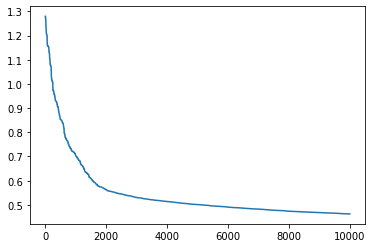

In [35]:
plt.plot(nn.fitness_curve[:,0])

In [17]:

para_grid = ({
  'learning_rate': [0.001],
  'restarts': [10, 25, 50],
  'activation': [mlrose_hiive.neural.activation.relu]
})
rhc_nn = mlrose_hiive.NNGSRunner(trn_X, trn_y, 
                                 test_X, test_y, 
                                 "NeuralNetworkRHC",
                                 iteration_list=[1000], 
                                 algorithm=mlrose_hiive.random_hill_climb,
                                 hidden_layer_sizes=[[200]],
                                 grid_search_parameters=para_grid,
                                 grid_search_scorer_method=partial(f1_score, average="weighted"),
                                 n_jobs=-2, cv=3, seed = 2022)
result = rhc_nn.run()

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [21]:
roc_auc_score(test_y, result[3].predict(test_X))

0.27565252358503045